### Import packages

In [1]:
options(stringsAsFactors = FALSE)
library(GenomicRanges)
library(scABC)
library(Rsamtools)
library(data.table)
library(dplyr)
library(tidyverse)
library(Matrix)

library(gplots) 
library(RColorBrewer)
library(devtools)
source_url("https://raw.githubusercontent.com/obigriffith/biostar-tutorials/master/Heatmaps/heatmap.3.R")

Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which.min

Loading required package: S4Ve

### Functions

In [2]:
bam2gr <- function(bamfile, PAIRED = FALSE) {
  if (PAIRED) {
    scanned = scanBam(bamfile, param = ScanBamParam(flag =scanBamFlag(isMinusStrand = FALSE,
                                                                      isUnmappedQuery = FALSE,
                                                                      isProperPair = TRUE),
                                                    what = c("rname", "pos", "isize")))[[1]]
    out = GRanges(seqnames = scanned$rname, IRanges(start = scanned$pos, width = scanned$isize))
  } else {
    scanned = scanBam(bamfile, param = ScanBamParam(flag =scanBamFlag(isUnmappedQuery = FALSE),
                                                    what = c("rname", "pos", "strand", "qwidth")))[[1]]
    out = GRanges(seqnames = scanned$rname,
                  IRanges(start = ifelse(scanned$strand == "-", scanned$pos + scanned$qwidth - 1, scanned$pos),
                          width = scanned$qwidth))
  }
  return(out)
}

getCountsByReadGroup <- function(bamfile, peaks, RGtag, tags = NULL, PAIRED = FALSE, VERBOSE = FALSE){
  scanned <- Rsamtools::scanBam(bamfile,
                     param = Rsamtools::ScanBamParam(flag =scanBamFlag(isUnmappedQuery = FALSE),
                                                     what = c("rname", "pos", "strand", "qwidth"),
                                                     tag = RGtag))[[1]]
  if(is.null(tags)){
    RGtags = unique(unlist(scanned$tag[RGtag]))
  }
  counts_mat = Matrix::Matrix(0, nrow = length(peaks), ncol = length(tags), sparse = TRUE)
  for(i in 1:length(tags)){
    tag = tags[i]
    if(VERBOSE){
      message("Processing tag ", tag)
    }
    match_RG <- which(scanned$tag[[RGtag]] == tag)
    # convert bamfiles to Genomic Ranges
    bam.gr = GenomicRanges::GRanges(seqnames = scanned$rname[match_RG],
                                    IRanges::IRanges(start = sapply(match_RG, function(i) ifelse(scanned$strand[i] == "-",
                                                                         scanned$pos[i] + scanned$qwidth[i] - 1,
                                                                         scanned$pos[i])),
                             width = scanned$qwidth[match_RG]))
    counts_mat[,i] = GenomicRanges::countOverlaps(peaks, bam.gr, type = "any", ignore.strand = TRUE)
  }
 # counts = do.call(cbind, lapply(RGtags, function(x) getTagCounts(x, bamfile, peaks)))
  colnames(counts_mat) = tags
  return(counts_mat)
}
                                    
peaks2GRanges <- function(peaks, upstream = 0, downstream = 0){
  peaks.gr = with(peaks, GenomicRanges::GRanges(chrom, IRanges::IRanges(sapply(start, function(x) max(0, x - upstream)), end + downstream), 
                                                                               id = name))#, pVal = pValue))
}

# peaks should be in GenomicRanges
get_counts_from_bam <- function(bamfile, peaks){
  param = Rsamtools::ScanBamParam(flag =scanBamFlag(isUnmappedQuery = FALSE), 
                                  which = peaks, 
                                  what = c("rname", "pos", "strand", "qwidth"))
  counts = Rsamtools::countBam(bamfile, param = param,
                               flag = Rsamtools::scanBamFlag(isDuplicate = FALSE,
                                                             isUnmappedQuery = FALSE))
  return(counts[,c("space", "start", "end", "file", "records")])
}
                                                

getCountsMatrix <- function(bamfiles, peaks, PAIRED = FALSE,
                            byReadGroup = FALSE, 
                            RGtag = 'RG',
                            tags2include = NULL, 
                            VERBOSE = FALSE){
  peaks.gr = peaks2GRanges(peaks)
  if(VERBOSE){
    message("beginning reading in counts\n")
  }
  if(byReadGroup){
    if(VERBOSE){
      message("getting counts by read group\n")
      message("read group tag = ", RGtag, "\n")
    }
    stopifnot(length(bamfiles) == 1)
    counts_mat = getCountsByReadGroup(bamfiles, peaks.gr, RGtag = RGtag, 
                                      tags = tags2include);
    rownames(counts_mat) = peaks$name
  }
  else{
    nCells = length(bamfiles)
    counts_mat = matrix(nrow = length(peaks.gr), ncol = nCells)
    for(i in 1:nCells){
      if(VERBOSE){
        message("Processing file ", bamfiles[i])
      }
      # convert bamfiles to Genomic Ranges
      bam.gr = bam2gr(bamfiles[i], PAIRED = PAIRED)
      counts_mat[,i] = countOverlaps(peaks.gr, bam.gr, type = "any", ignore.strand = TRUE)
    }
    colnames(counts_mat) = bamfiles
    rownames(counts_mat) = peaks$name
    #counts_info = data.frame(chrom = counts_list[[1]]$space, start = counts_list[[1]]$start, end = counts_list[[1]]$end, name = peaks$id, pValue = peaks$pVal)
  }
  peaks = peaks[,c("chrom", "start", "end", "name")]#, "pValue")]
  return(list(peaks = peaks, ForeGroundMatrix = Matrix::Matrix(counts_mat, sparse = TRUE)))
}
                                                
                                                
sort_peaks <- function(peaks){
  return(peaks[order(peaks$chrom, peaks$start), ])
}
                                                
selectPeaks <- function(filename, thresh = 2){
  peaks = read.csv(file = filename, header = FALSE, sep = "\t",
                     stringsAsFactors = FALSE);
  peaks = peaks[,1:3]
  if(dim(peaks)[2] == 15){
    # gapped peaks
    column_names = c("chrom", "start", "end", "name", "score", "strand",
                     "thickStart", "thickEnd", "itemRgb", "blockCount", "blockSizes",
                     "blockStarts", "signalValue", "pValue", "qValue");
    colnames(peaks) = column_names
    wanted_peaks = which(peaks$pValue > thresh); # pValue is -log10(p), p < 0.1 => pValue > 2
    peaks = sort_peaks(peaks[wanted_peaks, ])
  }
  if(dim(peaks)[2] == 10){
    # narrow peaks
    column_names = c("chrom", "start", "end", "name", "score", "strand",
                     "foldChange", "pValue", "qValue", "summit2PeakDist")
    colnames(peaks) = column_names
    wanted_peaks = which(peaks$pValue > thresh); # pValue is -log10(p), p < 0.1 => pValue > 2
    peaks = sort_peaks(peaks[wanted_peaks, ])
  }
  
  # mine  
  if(dim(peaks)[2] == 3){
    # gapped peaks
    column_names = c("chrom", "start", "end");
    colnames(peaks) = column_names
    peaks = sort_peaks(peaks)
  }
  return(peaks)
}
                                                
                                                
getBackground <- function(bamfiles, peaks, upstream = 500000,
                          downstream = 500000, byReadGroup = FALSE,
                          VERBOSE = FALSE, PAIRED = FALSE){
  nCells = length(bamfiles)
  background_peaks.gr = peaks2GRanges(peaks, upstream, downstream)
  if(byReadGroup){
    counts_mat = getCountsByReadGroup2(bamfile, background_peaks.gr);
    rownames(counts_mat) = peaks$name
  }
  else{
    counts_mat = matrix(nrow = length(background_peaks.gr), ncol = nCells)
    for(i in 1:nCells){
      if(VERBOSE){
        message("Processing file ", bamfiles[i])
      }
      # convert bamfiles to Genomic Ranges
      bam.gr = bam2gr(bamfiles[i], PAIRED = PAIRED)
      counts_mat[,i] = countOverlaps(background_peaks.gr, bam.gr, type = "any", ignore.strand = TRUE)
    }
    colnames(counts_mat) = bamfiles
    rownames(counts_mat) = peaks$name
    #counts_info = data.frame(chrom = counts_list[[1]]$space, start = counts_list[[1]]$start, end = counts_list[[1]]$end, name = peaks$id, pValue = peaks$pVal)
  }
  peaks = peaks[,c("chrom", "start", "end", "name")]#, "pValue")]
  return(list(peaks = peaks, BackGroundMatrix = Matrix::Matrix(counts_mat, sparse = TRUE)))
}

### Obtain Feature Matrix

In [3]:
start_time <- Sys.time()

In [4]:
metadata <- read.table('../../input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)

In [5]:
# loading input 1: single-cell BAM files
bamfiles <- list.files("../../input/sc-bams_nodup/", 
                       pattern = "*.bam", full.names = TRUE)

In [6]:
length(bamfiles)

[1] 2034

In [7]:
# loading input 2: peaks file
peaks <- selectPeaks("../../input/GSE96769_PeakFile_20160207.bed")
peaks$name <- paste("Peak", peaks$chrom, peaks$start, peaks$end, sep = "_")
dim(peaks)
head(peaks)

[1] 491437      4

chrom,start,end,name
chr1,10279,10779,Peak_chr1_10279_10779
chr1,13252,13752,Peak_chr1_13252_13752
chr1,16019,16519,Peak_chr1_16019_16519
chr1,29026,29526,Peak_chr1_29026_29526
chr1,96364,96864,Peak_chr1_96364_96864
chr1,115440,115940,Peak_chr1_115440_115940


In [8]:
ForeGround <- getCountsMatrix(bamfiles, peaks) 

In [9]:
ForeGroundFiltered <- filterPeaks(ForeGround$ForeGroundMatrix, peaks, 
                             nreads_thresh = 1, 
                             ncells_thresh = length(bamfiles)*0.01)

In [10]:
dim(peaks)
dim(ForeGroundFiltered$peaks)

[1] 491437      4

[1] 139517      4

In [11]:
fm_scABC = as.matrix(ForeGroundFiltered$ForeGroundMatrix)

In [12]:
dim(fm_scABC)
fm_scABC[1:5,1:5]

[1] 139517   2034

,../../input/sc-bams_nodup//BM1077-CLP-Frozen-160106-13.dedup.st.bam,../../input/sc-bams_nodup//BM1077-CLP-Frozen-160106-14.dedup.st.bam,../../input/sc-bams_nodup//BM1077-CLP-Frozen-160106-2.dedup.st.bam,../../input/sc-bams_nodup//BM1077-CLP-Frozen-160106-21.dedup.st.bam,../../input/sc-bams_nodup//BM1077-CLP-Frozen-160106-27.dedup.st.bam
Peak_chr1_10279_10779,0,0,0,0,0
Peak_chr1_13252_13752,0,0,0,0,0
Peak_chr1_16019_16519,0,0,0,0,0
Peak_chr1_29026_29526,0,0,0,0,0
Peak_chr1_96364_96864,0,0,0,0,0


In [13]:
end_time <- Sys.time()

In [14]:
end_time - start_time

Time difference of 9.157233 mins

In [15]:
all(sapply(strsplit(basename(colnames(fm_scABC)),'\\.'),'[', 1) == rownames(metadata))

[1] TRUE

In [16]:
colnames(fm_scABC) = rownames(metadata)

In [17]:
dim(fm_scABC)
fm_scABC[1:5,1:5]

[1] 139517   2034

,BM1077-CLP-Frozen-160106-13,BM1077-CLP-Frozen-160106-14,BM1077-CLP-Frozen-160106-2,BM1077-CLP-Frozen-160106-21,BM1077-CLP-Frozen-160106-27
Peak_chr1_10279_10779,0,0,0,0,0
Peak_chr1_13252_13752,0,0,0,0,0
Peak_chr1_16019_16519,0,0,0,0,0
Peak_chr1_29026_29526,0,0,0,0,0
Peak_chr1_96364_96864,0,0,0,0,0


In [18]:
saveRDS(fm_scABC, file = '../../output/feature_matrices/FM_scABC_buenrostro2018bulkpeaks.rds')

### Downstream Analysis

In [19]:
### Instead of normalizing the peaks-by-cells matrix, 
### weights calculated below will be used in k-medoid clustering step based on cell dissimilarity matrix: WeightedCluster::wcKMedoids(FGdist, k = nCluster, weights = weights);
### so it's not considered as part of feature matrix construction


# BackGround <- getBackground(bamfiles, ForeGroundFiltered$peaks, 
#                            upstream = 5e+05, downstream = 5e+05,
#                            PAIRED = FALSE, byReadGroup = FALSE)

# InSilicoForeGround = ForeGroundFiltered$ForeGroundMatrix
# InSilicoBackGround = BackGround$BackGroundMatrix
# InSilicoPeaks = ForeGroundFiltered$peaks

# fg.mat <- Matrix::Matrix(InSilicoForeGround, sparse = TRUE)
# bg.mat <- Matrix::Matrix(InSilicoBackGround, sparse = TRUE);

# weights = apply(bg.mat, 2, median);
# c = min(8, median(weights))
# # compute weighted k-medioids
# lambda = 1.0
# FGdist = 1 - sparseSpearmanCor(ForeGround);
# weights = 1/(1 + exp(-(weights - c)/(c*lambda)));

In [20]:
BackGround <- getBackground(bamfiles, ForeGroundFiltered$peaks, 
                           upstream = 5e+05, downstream = 5e+05,
                           PAIRED = FALSE, byReadGroup = FALSE)

In [21]:
InSilicoForeGround = ForeGroundFiltered$ForeGroundMatrix
InSilicoBackGround = BackGround$BackGroundMatrix
InSilicoPeaks = ForeGroundFiltered$peaks

In [22]:
#compute the landmarks
InSilicoLandMarks = computeLandmarks(ForeGround = InSilicoForeGround, 
                                      BackGround = InSilicoBackGround, 
                                      nCluster = length(unique(metadata$label)), lambda = 1, nTop = 2000)

In [23]:
cor(InSilicoLandMarks, InSilicoLandMarks, method = 'spearman')

1.0000000,0.2438309,0.4244481,0.2580935,0.2860021,0.4803328,0.5319120,0.4612757,0.5188308,0.4235940
0.2438309,1.0000000,0.3122203,0.1889295,0.2172000,0.3670636,0.3545203,0.3323311,0.3565220,0.3291958
0.4244481,0.3122203,1.0000000,0.2778499,0.3243910,0.6322385,0.6562546,0.5990578,0.6152552,0.5481999
0.2580935,0.1889295,0.2778499,1.0000000,0.1957895,0.3200940,0.3338121,0.3299704,0.3189125,0.2898136
0.2860021,0.2172000,0.3243910,0.1957895,1.0000000,0.3977447,0.3915297,0.3598874,0.3837491,0.3461507
0.4803328,0.3670636,0.6322385,0.3200940,0.3977447,1.0000000,0.8095506,0.7252495,0.8022158,0.6937151
0.5319120,0.3545203,0.6562546,0.3338121,0.3915297,0.8095506,1.0000000,0.7853849,0.7875049,0.6835954
0.4612757,0.3323311,0.5990578,0.3299704,0.3598874,0.7252495,0.7853849,1.0000000,0.6831432,0.6370474
0.5188308,0.3565220,0.6152552,0.3189125,0.3837491,0.8022158,0.7875049,0.6831432,1.0000000,0.6882970
0.4235940,0.3291958,0.5481999,0.2898136,0.3461507,0.6937151,0.6835954,0.6370474,0.6882970,1.0000000


In [24]:
# assign cells to the closest landmark #
InSilicoLandMarkAssignments = assign2landmarks(InSilicoForeGround, InSilicoLandMarks)

In [25]:
dim(InSilicoLandMarks)
head(InSilicoLandMarks)

[1] 139517     10

Peak_chr1_10279_10779,0,0,0,0,0,0,0,0,0,0
Peak_chr1_13252_13752,0,0,0,0,0,0,0,0,0,0
Peak_chr1_16019_16519,0,0,0,0,0,0,0,0,0,0
Peak_chr1_29026_29526,0,0,0,0,0,0,0,0,0,0
Peak_chr1_96364_96864,0,0,0,0,0,0,0,0,0,0
Peak_chr1_115440_115940,0,0,0,0,0,0,0,0,0,0


In [26]:
InSilicoCell2LandmarkCorrelation = do.call(cbind, 
                                           lapply(seq(length(unique(metadata$label))), 
                                                  function(i) apply(InSilicoForeGround, 2, 
                                                                    function(x) cor(x, InSilicoLandMarks[,i], method = 'spearman'))))

In [27]:
dim(InSilicoCell2LandmarkCorrelation)
InSilicoCell2LandmarkCorrelation[1:5,1:5]

[1] 2034   10

../../input/sc-bams_nodup//BM1077-CLP-Frozen-160106-13.dedup.st.bam,0.08336461,0.07699669,0.10098648,0.06328785,0.06847477
../../input/sc-bams_nodup//BM1077-CLP-Frozen-160106-14.dedup.st.bam,0.09077720,0.08197802,0.13509146,0.07880083,0.08514228
../../input/sc-bams_nodup//BM1077-CLP-Frozen-160106-2.dedup.st.bam,0.09872969,0.08986411,0.14400939,0.07550953,0.07808820
../../input/sc-bams_nodup//BM1077-CLP-Frozen-160106-21.dedup.st.bam,0.06944832,0.05367008,0.09072887,0.05064401,0.05782625
../../input/sc-bams_nodup//BM1077-CLP-Frozen-160106-27.dedup.st.bam,0.08314731,0.05730688,0.09469995,0.05840546,0.06595571


In [28]:
InSilicoLandMarkAssignments_sorted <- InSilicoLandMarkAssignments[order(InSilicoLandMarkAssignments)]
InSilicoCell2LandmarkCorrelation_sorted <- InSilicoCell2LandmarkCorrelation[names(InSilicoLandMarkAssignments_sorted),]

In [29]:
head(InSilicoCell2LandmarkCorrelation_sorted)

../../input/sc-bams_nodup//BM1077-CMP-Frozen-160106-33.dedup.st.bam,0.1346639,0.07255288,0.1099818,0.08466404,0.07972895,0.1169518,0.1243052,0.1089520,0.1185685,0.1123823
../../input/sc-bams_nodup//BM1077-CMP-Frozen-160106-37.dedup.st.bam,0.1597845,0.09066122,0.1216326,0.09655359,0.09909307,0.1502549,0.1564729,0.1507547,0.1541464,0.1349471
../../input/sc-bams_nodup//BM1077-CMP-Frozen-160106-50.dedup.st.bam,0.1181337,0.06196770,0.0961563,0.05657761,0.07550897,0.1114616,0.1151611,0.1141769,0.1126264,0.0959983
../../input/sc-bams_nodup//BM1077-CMP-Frozen-160106-95.dedup.st.bam,0.1384482,0.08042166,0.1169304,0.09450569,0.08563679,0.1308739,0.1301129,0.1212820,0.1367604,0.1193674
../../input/sc-bams_nodup//BM1077-HSC-Frozen-160105-1.dedup.st.bam,0.1725474,0.10743872,0.1353692,0.11934794,0.10842628,0.1568827,0.1663593,0.1484896,0.1640829,0.1417696
../../input/sc-bams_nodup//BM1077-HSC-Frozen-160105-10.dedup.st.bam,0.1893955,0.09720133,0.1375218,0.11086036,0.10874579,0.1541448,0.1572203,0.1480809,0.1595022,0.1366746


In [30]:
cell.ids = sapply(strsplit(basename(names(InSilicoLandMarkAssignments_sorted)),'\\.'),'[', 1)
head(cell.ids)
cell.labels = metadata[cell.ids,'label']
cell.info = match(metadata[cell.ids,'label'],unique(metadata[,'label']))
head(cell.info)

[1] "BM1077-CMP-Frozen-160106-33" "BM1077-CMP-Frozen-160106-37"
[3] "BM1077-CMP-Frozen-160106-50" "BM1077-CMP-Frozen-160106-95"
[5] "BM1077-HSC-Frozen-160105-1"  "BM1077-HSC-Frozen-160105-10"

[1] 2 2 2 2 4 4

In [31]:
scalered <- colorRampPalette(c("white", "red"), space = "rgb")(256)
rcols1 = colorRampPalette(brewer.pal(8, "Accent"))(length(unique(metadata$label)))
rowcols1 = rcols1[cell.info]
rcols2 = colorRampPalette(brewer.pal(8, "Dark2"))(length(unique(metadata$label)))
rowcols2 = rcols2[InSilicoLandMarkAssignments_sorted]
rowcols = rbind(rowcols1, rowcols2)
rownames(rowcols) = c("cell label", "cluster")

In [32]:
rowcols[,1:5]

cell label,#B0B4C1,#B0B4C1,#B0B4C1,#B0B4C1,#FDD58C
cluster,#1B9E77,#1B9E77,#1B9E77,#1B9E77,#1B9E77


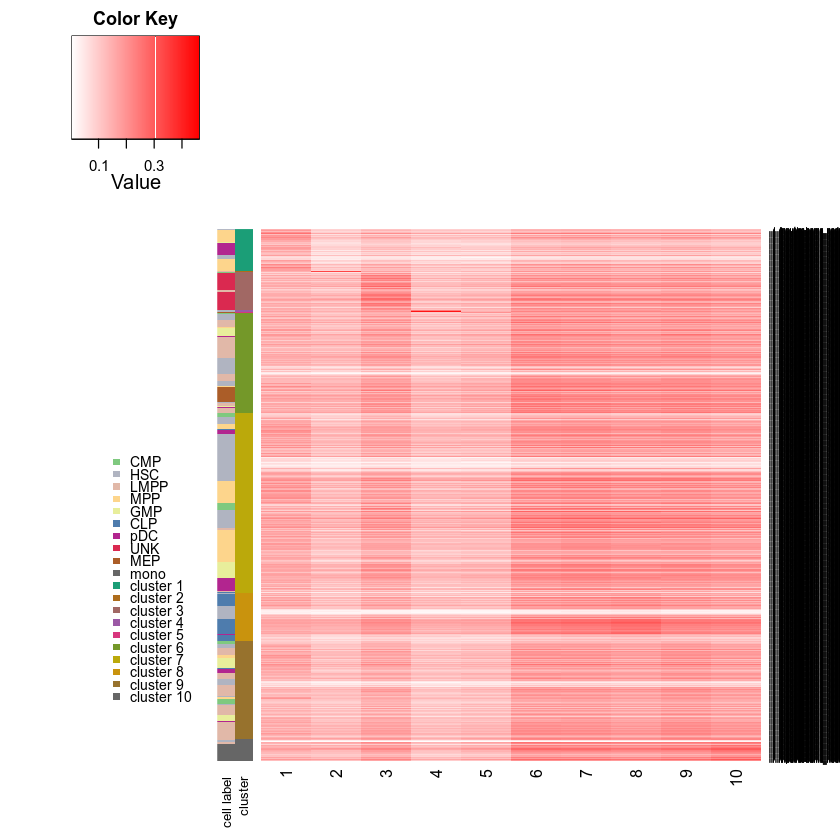

In [33]:
heatmap.3(InSilicoCell2LandmarkCorrelation_sorted, dendrogram='none', Rowv=FALSE, Colv=FALSE,
          trace='none', col = scalered, margin = c(5, 5), density.info = "none", 
          RowSideColors = rowcols, RowSideColorsSize=2, symm=F,symkey=F,
          symbreaks=F, scale="none")
legend("bottomleft", legend = c(unique(cell.labels), paste0("cluster ", 1:length(unique(metadata$label)))), 
       col = c(rcols1, rcols2), border=FALSE, bty="n", y.intersp = 0.7, cex=0.7, pch = 15)

In [34]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data/pinello/SHARED_SOFTWARE/anaconda3/envs/ATACseq_scABC/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] usethis_1.4.0        devtools_2.0.1       RColorBrewer_1.1-2  
 [4] gplots_3.0.1.1       Matrix_1.2-17        forcats_0.4.0       
 [7] stringr_1.4.0        purrr_0.3.2          readr_1.3.1         
[10] tidyr_0.8.3          tibble_2.1.1         ggpl

In [35]:
save.image(file = 'scABC_buenrostro2018bulkpeaks.RData')